# Neural network

An example of a feedforward neural network. We use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset to train the model in tensorflow.

## We will build a 2-layer neural network of the form:

![image](./images/NN2.png)

In [1]:
import numpy as np
import tensorflow as tf
import os
from util import get_log_path, plot15images, plotconfusion
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline


## We use the class Config to store all the hyperparameters

In [2]:
class Config():
    """
    Class to hold all model hyperparams.

    :type learning_rate: float
    :type batch_size: int
    :type image_size: int
    :type num_classes: int
    :type num_features: int
    :type num_epochs: int
    :type show_epoch: int
    :type log_path: None or str
    """
    def __init__(self,
                 learning_rate=0.001,
                 image_size=28,
                 batch_size=128,
                 num_classes=10,
                 num_features=784,
                 num_epochs=101,
                 show_epoch=10,
                 hidden_nodes_1=100,
                 hidden_nodes_2=50,
                 log_path=None):

        self.learning_rate = learning_rate
        self.image_size = image_size
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.num_features = num_features
        self.num_epochs = num_epochs
        self.show_epoch = show_epoch
        self.hidden_nodes_1 = hidden_nodes_1
        self.hidden_nodes_2 = hidden_nodes_2
        if log_path is None:
            self.log_path = get_log_path()
        else:
            self.log_path = log_path

## Tensorflow functions

In [3]:
def init_wb(shape, name):
    """
    Function initialize one matrix of weights and one bias vector.

    :type shape: tuple
    :type name: str
    :rtype: dictionary
    """
    Winit = tf.truncated_normal(shape, mean=0, stddev=0.1)
    binit = tf.zeros(shape[-1])
    layer = {}
    layer["weights"] = tf.get_variable(name + "/weights",
                                       dtype=tf.float32,
                                       initializer=Winit)
    layer["bias"] = tf.get_variable(name + "/bias",
                                    dtype=tf.float32,
                                    initializer=binit)
    return layer

def linear_activation(input_tensor, layer):
    """
    Function that applies the linear activation in the input tensor.

    :type input_tensor: tf tensor
    :type layer: dictionary
    :rtype: tf tensor
    """
    return tf.add(tf.matmul(input_tensor, layer['weights']),
                  layer['bias'])

## Defining a neural network as a tensorflow graph

In [4]:
class NeuralNetwork:
    """
    Neural network model with 2 hidden layers.

    :type config: Config
    """
    def __init__(self, config):

        self.learning_rate = config.learning_rate
        self.log_path = config.log_path
        self.batch_size = config.batch_size
        self.num_classes = config.num_classes
        self.num_features = config.num_features
        self.hidden_nodes_1 = config.hidden_nodes_1
        self.hidden_nodes_2 = config.hidden_nodes_2
        self.build_graph()

    def create_placeholders(self):
        """
        Method for creating the placeholder for input X (image).
        """
        with tf.variable_scope('Input_layer'):
            self.X = tf.placeholder(tf.float32,
                                    shape=(self.batch_size, self.num_features),
                                    name="X")

    def create_logits(self):
        """
        Method for creating logits:
        logits = relu(relu(xW_1 + b_1)W_2 + b_2)
        """
        with tf.variable_scope('Hidden_Layer1'):
            shape1 = [self.num_features, self.hidden_nodes_1]
            self.hidden_layer_1_wb = init_wb(shape1,
                                             'Params')
            linear1 = linear_activation(self.X, self.hidden_layer_1_wb)
            hidden_layer_1 = tf.nn.relu(linear1)
        with tf.variable_scope('Hidden_Layer2'):
            shape2 = [self.hidden_nodes_1, self.hidden_nodes_2]
            self.hidden_layer_2_wb = init_wb(shape2,
                                             'Params')
            linear2 = linear_activation(hidden_layer_1,
                                        self.hidden_layer_2_wb)
            hidden_layer_2 = tf.nn.relu(linear2)
        with tf.variable_scope('Output_Layer'):
            shape3 = [self.hidden_nodes_2, self.num_classes]
            self.hidden_layer_3_wb = init_wb(shape3,
                                             'Params')
            self.logits = linear_activation(hidden_layer_2,
                                            self.hidden_layer_3_wb)

    def create_summaries(self):
        """
        Method to create the histogram summaries for all weights
        """
        tf.summary.histogram('weights1_summ',
                             self.hidden_layer_1_wb['weights'])
        tf.summary.histogram('weights2_summ',
                             self.hidden_layer_2_wb['weights'])
        tf.summary.histogram('weights3_summ',
                             self.hidden_layer_3_wb['weights'])

    def create_loss(self):
        """
        Method for calculating the loss function
        unsing softmax and cross entropy.
        """
        with tf.name_scope("loss"):
            self.Y = tf.placeholder(tf.float32,
                                    shape=(self.batch_size, self.num_classes),
                                    name="Y")
            entropy_loss = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits,
                                                                   labels=self.Y)
            self.loss = tf.reduce_mean(entropy_loss)
            tf.summary.scalar("loss", self.loss)

    def create_optimizer(self):
        """
        Method to create the optimizer of the graph
        """
        with tf.name_scope("optimizer"):
            opt = tf.train.GradientDescentOptimizer(self.learning_rate)
            self.optimizer = opt.minimize(self.loss)

    def create_predictions(self):
        """
        Method to create the prediction for the placeholder.
        """
        with tf.name_scope("prediction"):
            prob_prediction = tf.nn.softmax(self.logits,
                                            name='X_prob_prediction')
            self.prediction = tf.argmax(prob_prediction,
                                        1,
                                        name='X_prediction')
            self.labes_cls = tf.argmax(self.Y,
                                       1,
                                       name='ground_truth')

    def create_accuracy(self):
        """
        Method to compute the accuracy of the model's predictions
        """
        with tf.name_scope('accuracy'):
            correct_pred = tf.equal(self.prediction,
                                    self.labes_cls)
            self.acc = tf.reduce_mean(tf.cast(correct_pred, 'float'))
            tf.summary.scalar('accuracy', self.acc)

    def create_saver(self):
        """
        Method to create the graph saver.
        """
        self.saver = tf.train.Saver()
        save_dir = 'checkpoints/'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        self.save_path = os.path.join(save_dir, 'best_validation')

    def build_graph(self):
        """
        Method to build the computation graph in tensorflow
        """
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.create_placeholders()
            self.create_logits()
            self.create_summaries()
            self.create_loss()
            self.create_optimizer()
            self.create_predictions()
            self.create_accuracy()
            self.create_saver()

## Using tensorboard to visualize the graph:


![image](./images/graph_NN.png)

## Function to train the model

In [5]:
def run_training(model, config, mnist, verbose=True):
    """
    Train the logistic regression model

    :type model: NeuralNetwork
    :type config: Config
    :type mnist: tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet
    :type verbose: boolean
    """

    num_samples = mnist.train.images.shape[0]
    batch_size = config.batch_size
    show_epoch = config.show_epoch
    num_epochs = config.num_epochs
    log_path = model.log_path
    with tf.Session(graph=model.graph) as sess:
        if verbose:
            print('Start training\n')
        summary_writer = tf.summary.FileWriter(log_path, sess.graph)
        all_summaries = tf.summary.merge_all()
        tf.global_variables_initializer().run()
        step = 0
        best_valid_acc = 0
        num_batches = int(num_samples / batch_size)
        for i in range(num_epochs):
            total_loss = 0
            for _ in range(num_batches):
                step += 1
                X_batch, Y_batch = mnist.train.next_batch(batch_size)
                feed_dict = {model.X: X_batch, model.Y: Y_batch}
                _, loss_batch, acc, summary = sess.run([model.optimizer,
                                                        model.loss,
                                                        model.acc,
                                                        all_summaries],
                                                        feed_dict=feed_dict)
                summary_writer.add_summary(summary, step)
                summary_writer.flush()
                total_loss += loss_batch
            if i % show_epoch == 0:
                X_batch_valid, Y_batch_valid = mnist.validation.next_batch(batch_size)
                feed_dict = {model.X: X_batch_valid, model.Y: Y_batch_valid}
                valid_acc = sess.run(model.acc, feed_dict=feed_dict)
                print('Average loss epoch {0}: {1}'.format(i, total_loss / num_batches))
                print('Minibatch acc epoch {}: {:.2f}%'.format(i, acc * 100))
                print('Valid minibatch acc epoch {}: {:.2f}%\n'.format(i, valid_acc * 100))
                if valid_acc > best_valid_acc:
                        best_valid_test = valid_acc
                        model.saver.save(sess=sess,
                                         save_path=model.save_path)
        if verbose:
            print("\n========= For TensorBoard visualization type ===========")
            print("\ntensorboard  --logdir={}\n".format(log_path))

## Loading the data

In [6]:
config = Config(num_epochs=51, show_epoch=10)
model = NeuralNetwork(config)
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
mnist.train.images.shape

(55000, 784)

## Visualizing some examples from the validation set

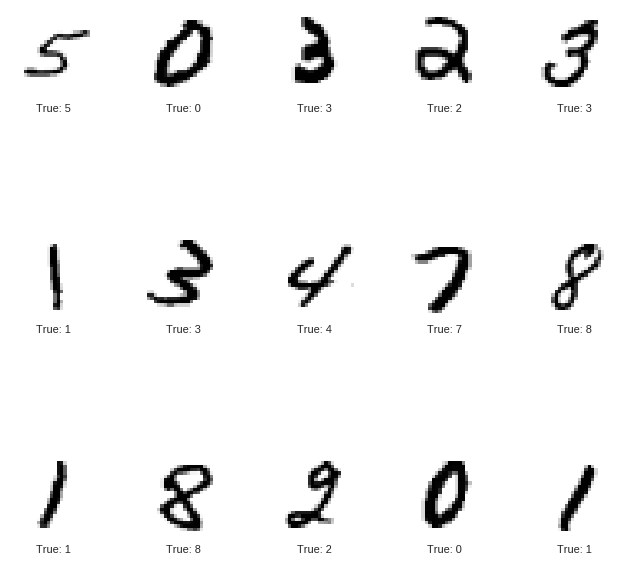

In [8]:
images, labels = mnist.validation.next_batch(15)
cls_true = np.argmax(labels, axis=1)
img_shape = (28, 28)
plot15images(images, cls_true, img_shape)

## Training the model

In [9]:
run_training(model, config, mnist)

Start training

Average loss epoch 0: 2.2942973166912584
Minibatch acc epoch 0: 21.09%
Valid minibatch acc epoch 0: 16.41%

Average loss epoch 10: 1.1496586289717046
Minibatch acc epoch 10: 74.22%
Valid minibatch acc epoch 10: 74.22%

Average loss epoch 20: 0.592511120792869
Minibatch acc epoch 20: 85.16%
Valid minibatch acc epoch 20: 82.03%

Average loss epoch 30: 0.4690454591821124
Minibatch acc epoch 30: 88.28%
Valid minibatch acc epoch 30: 90.62%

Average loss epoch 40: 0.41379398913372367
Minibatch acc epoch 40: 89.84%
Valid minibatch acc epoch 40: 89.06%

Average loss epoch 50: 0.3809497626997652
Minibatch acc epoch 50: 86.72%
Valid minibatch acc epoch 50: 87.50%


========= For TensorBoard visualization type ===========

tensorboard  --logdir=./graphs/24-07-2017_18-10-56



In [10]:
# ! tensorboard  --logdir= 

Starting TensorBoard b'54' at http://felsal:6006
(Press CTRL+C to quit)
^C


## Now we can predict the images from the test dataset

In [11]:
def predict(model, config, mnist):
    """
    Generate some predictions using a batch from the test dataset

    :type model: NeuralNetwork
    :type config: Config
    :type mnist: tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet
    :rtype X_batch: np array
    :rtype prediction: np array
    :rtype ground_truth: np array
    """
    batch_size = config.batch_size
    with tf.Session(graph=model.graph) as sess:
        model.saver.restore(sess=sess, save_path=model.save_path)
        X_batch, Y_batch = mnist.test.next_batch(batch_size)
        feed_dict = {model.X: X_batch, model.Y: Y_batch}
        predictions = sess.run(model.prediction,
                                    feed_dict=feed_dict)
    ground_truth = np.argmax(Y_batch, axis=1)
    return X_batch, predictions, ground_truth

## We can see if our predictions make sense

INFO:tensorflow:Restoring parameters from checkpoints/best_validation


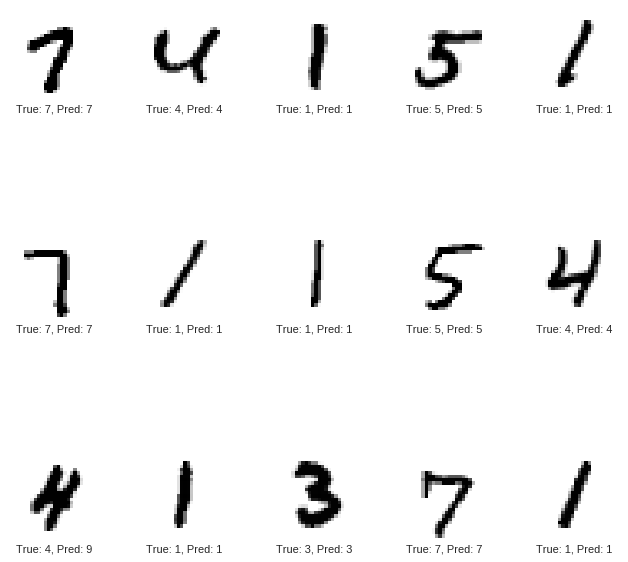

In [12]:
images, prediction, ground_truth = predict(model, config, mnist)
plot15images(images[0:15], ground_truth[0:15], img_shape, prediction[0:15])

## We can also plot the confusion matrix

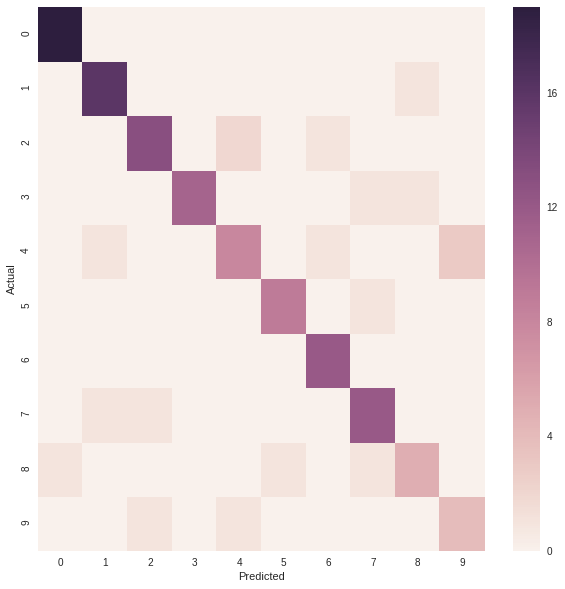

In [13]:
plotconfusion(ground_truth, prediction)